# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [94]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [95]:
# Define transforms
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
#[0.491, 0.482, 0.447], [0.247, 0.244, 0.262]
root_dir = "./data"
batch_size = 10

# Create training set and define training dataloader
train_image_datasets = torchvision.datasets.CIFAR10(root=root_dir, train=True, transform=data_transforms, download=True)
train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
test_image_datasets = torchvision.datasets.CIFAR10(root=root_dir, train=False, transform=data_transforms, download=True)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [96]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


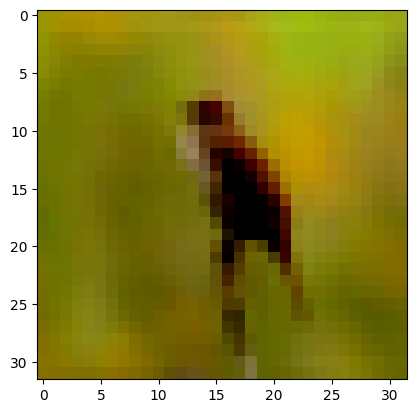

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


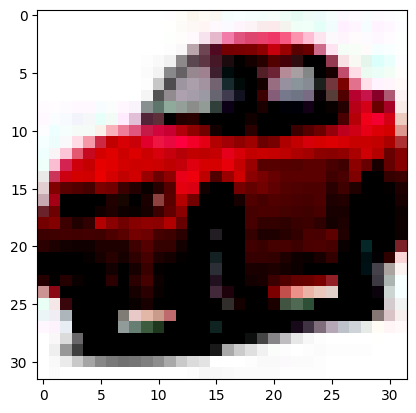

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


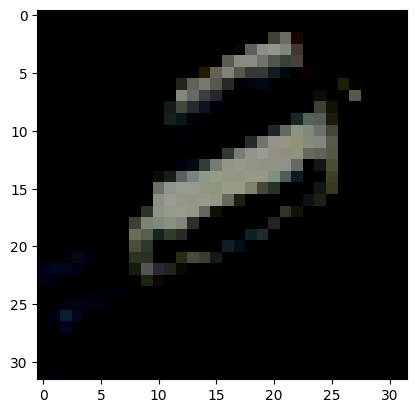

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


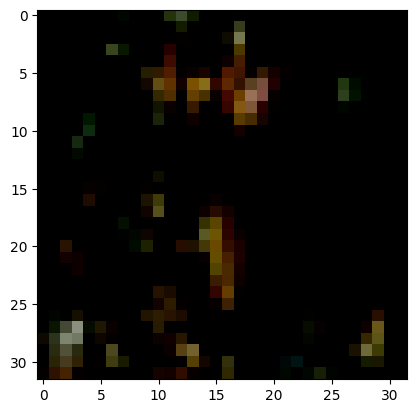

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


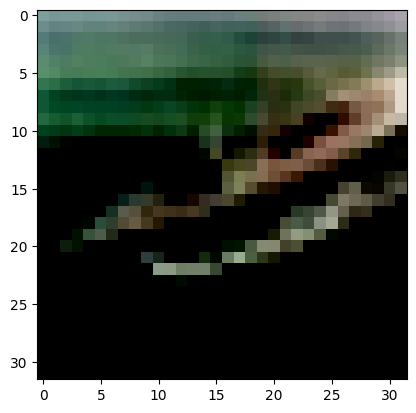

In [97]:
# Explore data
show5(train_dataloaders);

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [98]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(256 * 2 * 2, 502)
        self.fc2 = nn.Linear(502, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [99]:
## YOUR CODE HERE ##
model = ConvNet()
optimizer = optim.Adam(params=model.parameters(), lr=0.002)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [100]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()
epochs = 1
steps = 0
print_every = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_loss_list = []
validation_loss_list = []

if os.path.exists('checkpoint.pth'):
    print("Loading from checkpoint ...\n")
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    print("Loading fresh model state ...")

accuracy = 0

print("Starting training ... ")
for e in range(epochs):
    train_running_loss = 0
    
    for images, labels in train_dataloaders:
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        train_running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        steps += 1
        
        if steps % print_every == 0:
            test_running_loss = 0
            accuracy = 0
            model.eval()
            
            for images, labels in test_dataloaders:
                images, labels = images.to(device), labels.to(device)
                
                logits = model(images)
                loss = criterion(logits, labels)
                
                test_running_loss += loss.item()
                
                ps = torch.exp(logits)
                top_ps, top_class = ps.topk(1, dim=1)
                
                equal = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equal.type(torch.FloatTensor))
             
            training_loss_list.append(train_running_loss/steps)
            validation_loss_list.append(test_running_loss/len(test_dataloaders))
            
            print(f"Epoch: {e+1}/{epochs}... "
                  f"Training loss: {train_running_loss/steps:.3f}... "
                  f"Test loss: {test_running_loss/len(test_dataloaders):.3f}... "
                  f"Test accuracy: {accuracy/len(test_dataloaders):.3f}..."
                 )
            
            model.train()
            train_running_loss = 0 
            
print(f"... Training completed with {(accuracy/len(test_dataloaders)) * 100}%")
                

Loading from checkpoint ...

Starting training ... 
Epoch: 1/1... Training loss: 1.340... Test loss: 1.312... Test accuracy: 0.528...
Epoch: 1/1... Training loss: 0.670... Test loss: 1.317... Test accuracy: 0.528...
Epoch: 1/1... Training loss: 0.412... Test loss: 1.314... Test accuracy: 0.535...
Epoch: 1/1... Training loss: 0.340... Test loss: 1.339... Test accuracy: 0.527...
Epoch: 1/1... Training loss: 0.312... Test loss: 1.318... Test accuracy: 0.531...
Epoch: 1/1... Training loss: 0.219... Test loss: 1.297... Test accuracy: 0.540...
Epoch: 1/1... Training loss: 0.205... Test loss: 1.333... Test accuracy: 0.521...
Epoch: 1/1... Training loss: 0.158... Test loss: 1.339... Test accuracy: 0.522...
Epoch: 1/1... Training loss: 0.133... Test loss: 1.310... Test accuracy: 0.528...
Epoch: 1/1... Training loss: 0.122... Test loss: 1.332... Test accuracy: 0.522...
Epoch: 1/1... Training loss: 0.120... Test loss: 1.357... Test accuracy: 0.521...
Epoch: 1/1... Training loss: 0.097... Test los

Epoch: 1/1... Training loss: 0.013... Test loss: 1.309... Test accuracy: 0.537...
Epoch: 1/1... Training loss: 0.013... Test loss: 1.302... Test accuracy: 0.539...
Epoch: 1/1... Training loss: 0.012... Test loss: 1.303... Test accuracy: 0.537...
Epoch: 1/1... Training loss: 0.013... Test loss: 1.352... Test accuracy: 0.513...
Epoch: 1/1... Training loss: 0.012... Test loss: 1.317... Test accuracy: 0.531...
Epoch: 1/1... Training loss: 0.012... Test loss: 1.433... Test accuracy: 0.498...
Epoch: 1/1... Training loss: 0.013... Test loss: 1.325... Test accuracy: 0.530...
Epoch: 1/1... Training loss: 0.011... Test loss: 1.332... Test accuracy: 0.528...
Epoch: 1/1... Training loss: 0.011... Test loss: 1.342... Test accuracy: 0.530...
Epoch: 1/1... Training loss: 0.013... Test loss: 1.387... Test accuracy: 0.518...
Epoch: 1/1... Training loss: 0.011... Test loss: 1.297... Test accuracy: 0.532...
Epoch: 1/1... Training loss: 0.013... Test loss: 1.272... Test accuracy: 0.543...
Epoch: 1/1... Tr

Epoch: 1/1... Training loss: 0.007... Test loss: 1.295... Test accuracy: 0.535...
Epoch: 1/1... Training loss: 0.007... Test loss: 1.321... Test accuracy: 0.527...
Epoch: 1/1... Training loss: 0.006... Test loss: 1.352... Test accuracy: 0.521...
Epoch: 1/1... Training loss: 0.007... Test loss: 1.313... Test accuracy: 0.533...
Epoch: 1/1... Training loss: 0.006... Test loss: 1.352... Test accuracy: 0.506...
Epoch: 1/1... Training loss: 0.006... Test loss: 1.331... Test accuracy: 0.530...
Epoch: 1/1... Training loss: 0.007... Test loss: 1.321... Test accuracy: 0.533...
Epoch: 1/1... Training loss: 0.006... Test loss: 1.280... Test accuracy: 0.547...
Epoch: 1/1... Training loss: 0.007... Test loss: 1.295... Test accuracy: 0.547...
Epoch: 1/1... Training loss: 0.005... Test loss: 1.302... Test accuracy: 0.542...
Epoch: 1/1... Training loss: 0.006... Test loss: 1.267... Test accuracy: 0.553...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.261... Test accuracy: 0.551...
Epoch: 1/1... Tr

Epoch: 1/1... Training loss: 0.004... Test loss: 1.267... Test accuracy: 0.546...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.241... Test accuracy: 0.557...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.237... Test accuracy: 0.559...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.272... Test accuracy: 0.548...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.293... Test accuracy: 0.550...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.317... Test accuracy: 0.536...
Epoch: 1/1... Training loss: 0.005... Test loss: 1.240... Test accuracy: 0.557...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.277... Test accuracy: 0.540...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.269... Test accuracy: 0.550...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.280... Test accuracy: 0.546...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.294... Test accuracy: 0.538...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.292... Test accuracy: 0.543...
Epoch: 1/1... Tr

Epoch: 1/1... Training loss: 0.003... Test loss: 1.228... Test accuracy: 0.576...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.252... Test accuracy: 0.565...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.307... Test accuracy: 0.554...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.251... Test accuracy: 0.566...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.300... Test accuracy: 0.542...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.220... Test accuracy: 0.569...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.249... Test accuracy: 0.561...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.243... Test accuracy: 0.561...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.260... Test accuracy: 0.553...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.240... Test accuracy: 0.558...
Epoch: 1/1... Training loss: 0.003... Test loss: 1.216... Test accuracy: 0.570...
Epoch: 1/1... Training loss: 0.004... Test loss: 1.268... Test accuracy: 0.563...
Epoch: 1/1... Tr

Plot the training loss (and validation loss/accuracy, if recorded).

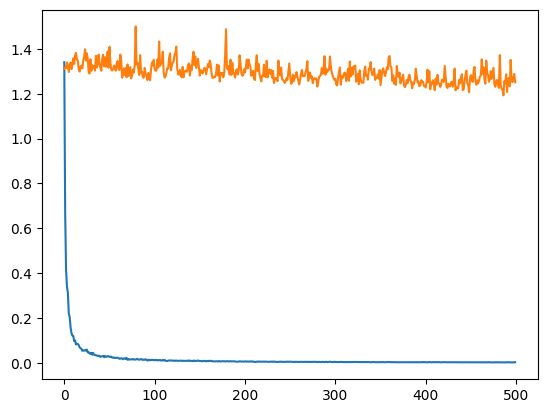

In [101]:
## YOUR CODE HERE ##

plt.plot(training_loss_list)
plt.plot(validation_loss_list)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [103]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloaders:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 56%


## Saving your model
Using `torch.save`, save your model for future loading.

In [104]:
## YOUR CODE HERE ##
model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()

checkpoint = {
    'state_dict': model_state_dict,
    'optimizer_state_dict': optimizer_state_dict
}

torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?


Based on my evaluation, I will recommend that the company go with Datacorps algorithm for the fact that it has 70% accuracy compared to mine that has a 56% accuracy.

To achieve this accuracy, I built a convolutional neural network that has 3 convolutional layer with 64,128 and 256 kernels respectively with a 3by3 filter and a stride of 1. Between each covolution is a 2by2 maxpool layer and a reLU activation. The result of the convolution layers is then fed into fully connected layers with a dropout of 2% in the second layer. The model was trained over 2 epochs with a learning rate of 0.002. The initial architecture started with 2 conolutional layer and was tweaked to arive at the one above.

It will be neccessary to improve the accuracy of the model. This can be improved in couple of ways which could include; modifying the architecture, changing the learning rate, changing the optimizer or loss function and increasing the epochs. 


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).